In [1]:
# !python /home/vs428/Documents/deep-ed-diags/simple_nn_runner.py

# Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Path hack.
import sys
import os

sys.path.append(os.path.abspath(".."))

In [4]:
import csv
import ast
from datetime import date, datetime, time, timedelta
from datetime import datetime
import pickle as pkl
import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.utils.class_weight import compute_class_weight

import numpy as np
import pandas as pd
import sklearn
from joblib import dump, load

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from models.simple_nn import *

In [5]:
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, query_cols, sorter=sidx)]


def flatten(t):
    return [item for sublist in t for item in sublist]

# Read in Model

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.utils.class_weight import compute_class_weight

import numpy as np
import pandas as pd
import sklearn
from joblib import dump, load

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from models.simple_nn import *
from models.simple_nn_lightning import *

In [92]:
RUN_NAME = "super-sweep-31"

In [93]:
checkpoint = torch.load(
    f"/gpfs/milgram/project/rtaylor/shared/ABDPain_EarlyDiags/models/{RUN_NAME}.model.ckpt",
    map_location=torch.device('cpu')
)
# model.eval()

In [95]:
checkpoint['state_dict']

OrderedDict([('fc1.weight',
              tensor([[-0.0269,  0.0235,  0.0403,  ..., -0.0050,  0.0152, -0.0243],
                      [ 0.0544,  0.0094, -0.0081,  ...,  0.0007, -0.0064,  0.0220],
                      [ 0.0743, -0.0353,  0.0644,  ..., -0.0379, -0.0194,  0.0281],
                      ...,
                      [-0.0121,  0.0400,  0.0439,  ...,  0.0073, -0.0426, -0.0400],
                      [ 0.0790,  0.0161, -0.0380,  ..., -0.0374, -0.0430,  0.0284],
                      [ 0.1091,  0.0006, -0.0009,  ...,  0.0412,  0.0140,  0.0182]])),
             ('fc1.bias',
              tensor([     0.0267,      0.0045,      0.0007,      0.0395,     -0.0190,
                           0.0590,      0.0116,      0.0121,      0.0501,      0.0367,
                          -0.0162,      0.0370,      0.0109,      0.0428,     -0.0247,
                          -0.0123,     -0.0116,     -0.0007,     -0.0133,      0.0079,
                           0.0466,      0.0467,     -0.0089,    

In [98]:
model = LitAbdPainPredictionMLP.load_from_checkpoint(f"/gpfs/milgram/project/rtaylor/shared/ABDPain_EarlyDiags/models/{RUN_NAME}.model.ckpt",
                                                    input_dim=590, n_classes=64, layer_size=128, strict=False)

/gpfs/milgram/project/rtaylor/vs428/conda_envs/factcheck_env/lib/python3.7/site-packages/pytorch_lightning/core/saving.py:213: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['loss.pos_weight']
  f"Found keys that are not in the model state dict but in the checkpoint: {keys.unexpected_keys}"


In [99]:
# checkpoint

In [100]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Dataset

In [101]:
from sklearn.model_selection import cross_val_score

# from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold


import optuna


import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay

In [102]:
data = pd.read_pickle(
        f"/gpfs/milgram/project/rtaylor/shared/ABDPain_EarlyDiags/unq_pt_enc_clean_multilabel_nomis_dvemb.pkl",
#     f"/gpfs/milgram/project/rtaylor/shared/ABDPain_EarlyDiags/unq_pt_enc_clean_multilabel_nomismatches.pkl",
    #                   nrows=50000
)

In [103]:
with open("../label_list.txt", "r") as f:
    label_list = f.read().splitlines()

In [104]:
label_list

['Abdominal Pain, general',
 'Abdominal aortic aneurysm',
 'Abdominal migraine',
 'Abortion',
 'Acute cystitis',
 'Acute gastroenteritis',
 'Aortic dissection',
 'Appendicitis',
 'Bowel obstruction',
 'Bowel perforation',
 'CHF',
 'Cholangitis',
 'Colitis',
 'Colon cancer',
 'Constipation',
 'Diabetic ketoacidosis',
 'Diverticulitis',
 'Ectopic pregnancy',
 'Flank pain/renal colic',
 'Gastritis',
 'Gastroesophageal reflux disease (GERD)',
 'Gastroparesis',
 'Glaucoma',
 'Hepatitis',
 'Hernia',
 'Herpes zoster',
 'Inflammatory Disease of the Uterus/Endometriosis',
 'Inflammatory bowel disease',
 'Irritable bowel syndrome',
 'Labor/Preterm Labor',
 "Meckel's diverticulum",
 'Mesenteric ischemia',
 'Mesenteric lymphadenitis',
 'Methanol Poisoning',
 'Mittelschmerz',
 'Mononucleosis',
 'Muscle spasm',
 'Myoma (degenerating)',
 'Ovarian cyst',
 'Pancreatitis',
 'Paroxysmal nocturnal hemoglobinuria',
 'Pelvic inflammatory disease',
 'Peptic ulcer disease with or without perforation',
 'Peric

In [105]:
from collections import Counter

value_counts = pd.Series(Counter(flatten(data["multilabel"].tolist())))

In [106]:
value_counts.sort_values()

Placental Abruption                        2
Paroxysmal nocturnal hemoglobinuria        3
Uremia                                     4
Porphyria                                  5
Labor/Preterm Labor                        6
                                       ...  
Constipation                            8518
Colitis                                 9024
Urolithiasis                           11371
Acute cystitis                         13426
Abdominal Pain, general                67156
Length: 64, dtype: int64

In [107]:
(value_counts.sum() - value_counts) / (value_counts)

Renal Failure                 50.142324
Appendicitis                  26.602757
Urolithiasis                  14.674171
Abdominal Pain, general        1.653985
Gastritis                     34.265334
                               ...     
Meckel's diverticulum      17822.100000
Glaucoma                   11881.066667
Uremia                     44556.750000
Porphyria                  35645.200000
Labor/Preterm Labor        29704.166667
Length: 64, dtype: float64

In [108]:
print(f"dataset size: {data.shape}")

dataset size: (162392, 4347)


In [109]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [110]:
non_train_col_mask = (
    data.columns[data.columns.str.contains("EdDisposition_")]
    .union(data.columns[:3], sort=False)
    .union(pd.Index(["multilabel"]), sort=False)
)
train_col_mask = data.columns.difference(non_train_col_mask, sort=False)

In [111]:
X_train, X_test, y_train, y_test = train_test_split(
    data[train_col_mask],
    data["multilabel"],
    test_size=0.2,
    random_state=314,
)

In [112]:
#################
### Data Load ###
#################

std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()


# drop all columns that don't have any positive actual values/only have all NaNs
data = data.drop(
    data.columns[((data.shape[0] - data.isnull().sum()) == 0)], axis=1, errors="ignore"
)

# remove columns that don't have at least N (hyperparam) number of non-NaN values
data = data[
    data.columns.intersection(
        data.columns[(((data.shape[0] - data.isnull().sum())) > 5)]
    )
]
print(f"After dropping sparse columns: {data.shape}")

data.columns = data.columns.str.replace("[|]|<", "leq_")
# logging.info(f"Dropped {droppable_rows} rows for stratified K-fold with {single_support_classes} classes")

# drop EDDisposition, ID, and label columns
non_train_col_mask = (
    data.columns[data.columns.str.contains("EdDisposition_")]
    .union(data.columns[:3], sort=False)
    .union(pd.Index(["multilabel"]), sort=False)
)
train_col_mask = data.columns.difference(non_train_col_mask, sort=False)

After dropping sparse columns: (162392, 2556)


/gpfs/milgram/project/rtaylor/vs428/conda_envs/factcheck_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: The default value of regex will change from True to False in a future version.


### read in col types that we used in model training

In [113]:
col_idxs = []
with open(
    f"/gpfs/milgram/project/rtaylor/shared/ABDPain_EarlyDiags/model_metadata/{RUN_NAME}_metadata.txt",
    "r",
    encoding="unicode_escape",
) as f:
    for line in f:
        col_idxs.append(line)

In [114]:
import ast

cat_cols = ast.literal_eval(col_idxs[1])
normal_cols = ast.literal_eval(col_idxs[3])
all_other_cols = ast.literal_eval(col_idxs[5])
label_list = ast.literal_eval(col_idxs[7])

In [115]:
# Create a dummy index variable to get the indices
indices = range(data.shape[0])
X_train, X_test, y_train, y_test, idxs_train, idxs_test = train_test_split(
    data[train_col_mask],
    data["multilabel"],
    indices,
    #                                                     stratify=train_test_stratify,
    test_size=0.2,
    random_state=314,
)

print(data[train_col_mask].shape)
print(X_train.shape)

# get the indices for the pandas column names
cat_col_idxs = column_index(data[train_col_mask], train_col_mask.intersection(cat_cols))
normal_col_idxs = column_index(
    data[train_col_mask], train_col_mask.intersection(normal_cols)
)
all_other_cols_idxs = column_index(
    data[train_col_mask], train_col_mask.intersection(all_other_cols)
)


# fit the indices by data type
# we check if there are any such columns
# if not, this fails silently by indexing with empty arrays
if len(normal_col_idxs) > 0:
    std_scaler.fit(X_train.iloc[:, normal_col_idxs])
    X_train_std_scaled = std_scaler.transform(X_train.iloc[:, normal_col_idxs])
    X_test_std_scaled = std_scaler.transform(X_test.iloc[:, normal_col_idxs])
else:
    X_train_std_scaled = np.array([])
    X_test_std_scaled = np.array([])

if len(all_other_cols_idxs) > 0:
    minmax_scaler.fit(X_train.iloc[:, all_other_cols_idxs])
    X_train_minmax_scaled = minmax_scaler.transform(
        X_train.iloc[:, all_other_cols_idxs]
    )
    X_test_minmax_scaled = minmax_scaler.transform(X_test.iloc[:, all_other_cols_idxs])
else:
    X_train_minmax_scaled = np.array([])
    X_test_minmax_scaled = np.array([])

# scale/normalize based on the column idxs above
X_train_input = torch.zeros(X_train.values.shape)
X_test_input = torch.zeros(X_test.values.shape)

(162392, 2542)
(129913, 2542)


In [116]:
### TODO: The error is in this line where the transform function expects what we trained on, which we aren't using here. terrible.
X_train_input[:, cat_col_idxs] = torch.tensor(
    np.nan_to_num(X_train.iloc[:, cat_col_idxs]), dtype=torch.float
)

X_train_input[:, normal_col_idxs] = torch.tensor(
    np.nan_to_num(X_train_std_scaled), dtype=torch.float
)
X_train_input[:, all_other_cols_idxs] = torch.tensor(
    np.nan_to_num(X_train_minmax_scaled), dtype=torch.float
)


X_test_input[:, cat_col_idxs] = torch.tensor(
    np.nan_to_num(X_test.iloc[:, cat_col_idxs]), dtype=torch.float
)
X_test_input[:, normal_col_idxs] = torch.tensor(
    np.nan_to_num(X_test_std_scaled), dtype=torch.float
)
X_test_input[:, all_other_cols_idxs] = torch.tensor(
    np.nan_to_num(X_test_minmax_scaled), dtype=torch.float
)

In [117]:
X_train_input = X_train_input[
    :, list(cat_col_idxs) + list(normal_col_idxs) + list(all_other_cols_idxs)
]
X_test_input = X_test_input[
    :, list(cat_col_idxs) + list(normal_col_idxs) + list(all_other_cols_idxs)
]

In [118]:
X_train_input.shape, X_test_input.shape

(torch.Size([129913, 590]), torch.Size([32479, 590]))

In [119]:
# we need to store this value for the NN model definition
INPUT_DIM = X_train.shape[1]

# For the multilabel case, we have to transform the y_train and y_test datasets ourselves
y_train_input = torch.zeros(X_train_input.shape[0], len(label_list), dtype=torch.float)
y_test_input = torch.zeros(X_test_input.shape[0], len(label_list), dtype=torch.float)

for row_idx, (_, labels) in enumerate(y_train.items()):
    y_train_input[row_idx, :] = torch.tensor(
        np.isin(label_list, labels, assume_unique=True).astype(float)
    )

for row_idx, (_, labels) in enumerate(y_test.items()):
    y_test_input[row_idx, :] = torch.tensor(
        np.isin(label_list, labels, assume_unique=True).astype(float)
    )

In [120]:
X_train_input.shape, y_train_input.shape

(torch.Size([129913, 590]), torch.Size([129913, 64]))

In [121]:
X_test_input.shape, y_test_input.shape

(torch.Size([32479, 590]), torch.Size([32479, 64]))

In [122]:
model

LitAbdPainPredictionMLP(
  (fc1): Linear(in_features=590, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [123]:
# y_pred = clf.predict_proba(X_test)
model = model.to(device)
out = model(torch.tensor(X_test_input).float().to(device))

/gpfs/milgram/project/rtaylor/vs428/conda_envs/factcheck_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [124]:
out[out >= 0.5] = 1
out[out < 0.5] = 0  ## assign 0 label to those with less than 0.5

In [125]:
out.shape, y_test_input.shape

(torch.Size([32479, 64]), torch.Size([32479, 64]))

In [126]:
from sklearn.metrics import multilabel_confusion_matrix

In [127]:
conf_mat = multilabel_confusion_matrix(
    y_test_input.cpu().detach().numpy(), out.cpu().detach().numpy()
)

In [128]:
conf_mat.shape

(64, 2, 2)

In [129]:
y_test_input.shape

torch.Size([32479, 64])

In [130]:
conf_mat[40, :, :]

array([[32478,     0],
       [    1,     0]])

# Plot

In [131]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [147]:
from itertools import chain, zip_longest
def twolists(l1, l2):
    return [x for x in chain(*zip_longest(l1, l2)) if x is not None]

Abdominal 
 Pain, 
 general 

Abdominal 
 aortic 
 aneurysm 

Abdominal 
 migraine 

Abortion 

Acute 
 cystitis 

Acute 
 gastroenteritis 

Aortic 
 dissection 

Appendicitis 

Bowel 
 obstruction 

Bowel 
 perforation 

CHF 

Cholangitis 

Colitis 

Colon 
 cancer 

Constipation 

Diabetic 
 ketoacidosis 

Diverticulitis 

Ectopic 
 pregnancy 

Flank 
 pain/renal 
 colic 

Gastritis 



/gpfs/milgram/project/rtaylor/vs428/conda_envs/factcheck_env/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Gastroesophageal 
 reflux 
 disease 
 (GERD) 

Gastroparesis 

Glaucoma 

Hepatitis 

Hernia 

Herpes 
 zoster 

Inflammatory 
 Disease 
 of 
 the 
 Uterus/Endometriosis 

Inflammatory 
 bowel 
 disease 

Irritable 
 bowel 
 syndrome 

Labor/Preterm 
 Labor 

Meckel's 
 diverticulum 

Mesenteric 
 ischemia 

Mesenteric 
 lymphadenitis 

Methanol 
 Poisoning 

Mittelschmerz 

Mononucleosis 

Muscle 
 spasm 

Myoma 
 (degenerating) 

Ovarian 
 cyst 

Pancreatitis 

Paroxysmal 
 nocturnal 
 hemoglobinuria 

Pelvic 
 inflammatory 
 disease 

Peptic 
 ulcer 
 disease 
 with 
 or 
 without 
 perforation 

Pericarditis/Myocarditis 

Peritonitis 

Placental 
 Abruption 

Pneumonia 

Porphyria 

Psoas 
 abscess 

Pulmonary 
 embolism 

Renal 
 Failure 

STI 

Sepsis 

Sexual 
 assault/trauma 

Sickle 
 Cell 
 Crisis 

Splenic 
 infarction/Splenic 
 artery 
 aneurysm 
 rupture 

Strep 
 Pharyngitis 
 (peds) 

Systemic 
 lupus 
 erythematosus 

Testicular 
 Torsion 

Uremia 

Urolithiasis 

Vagin

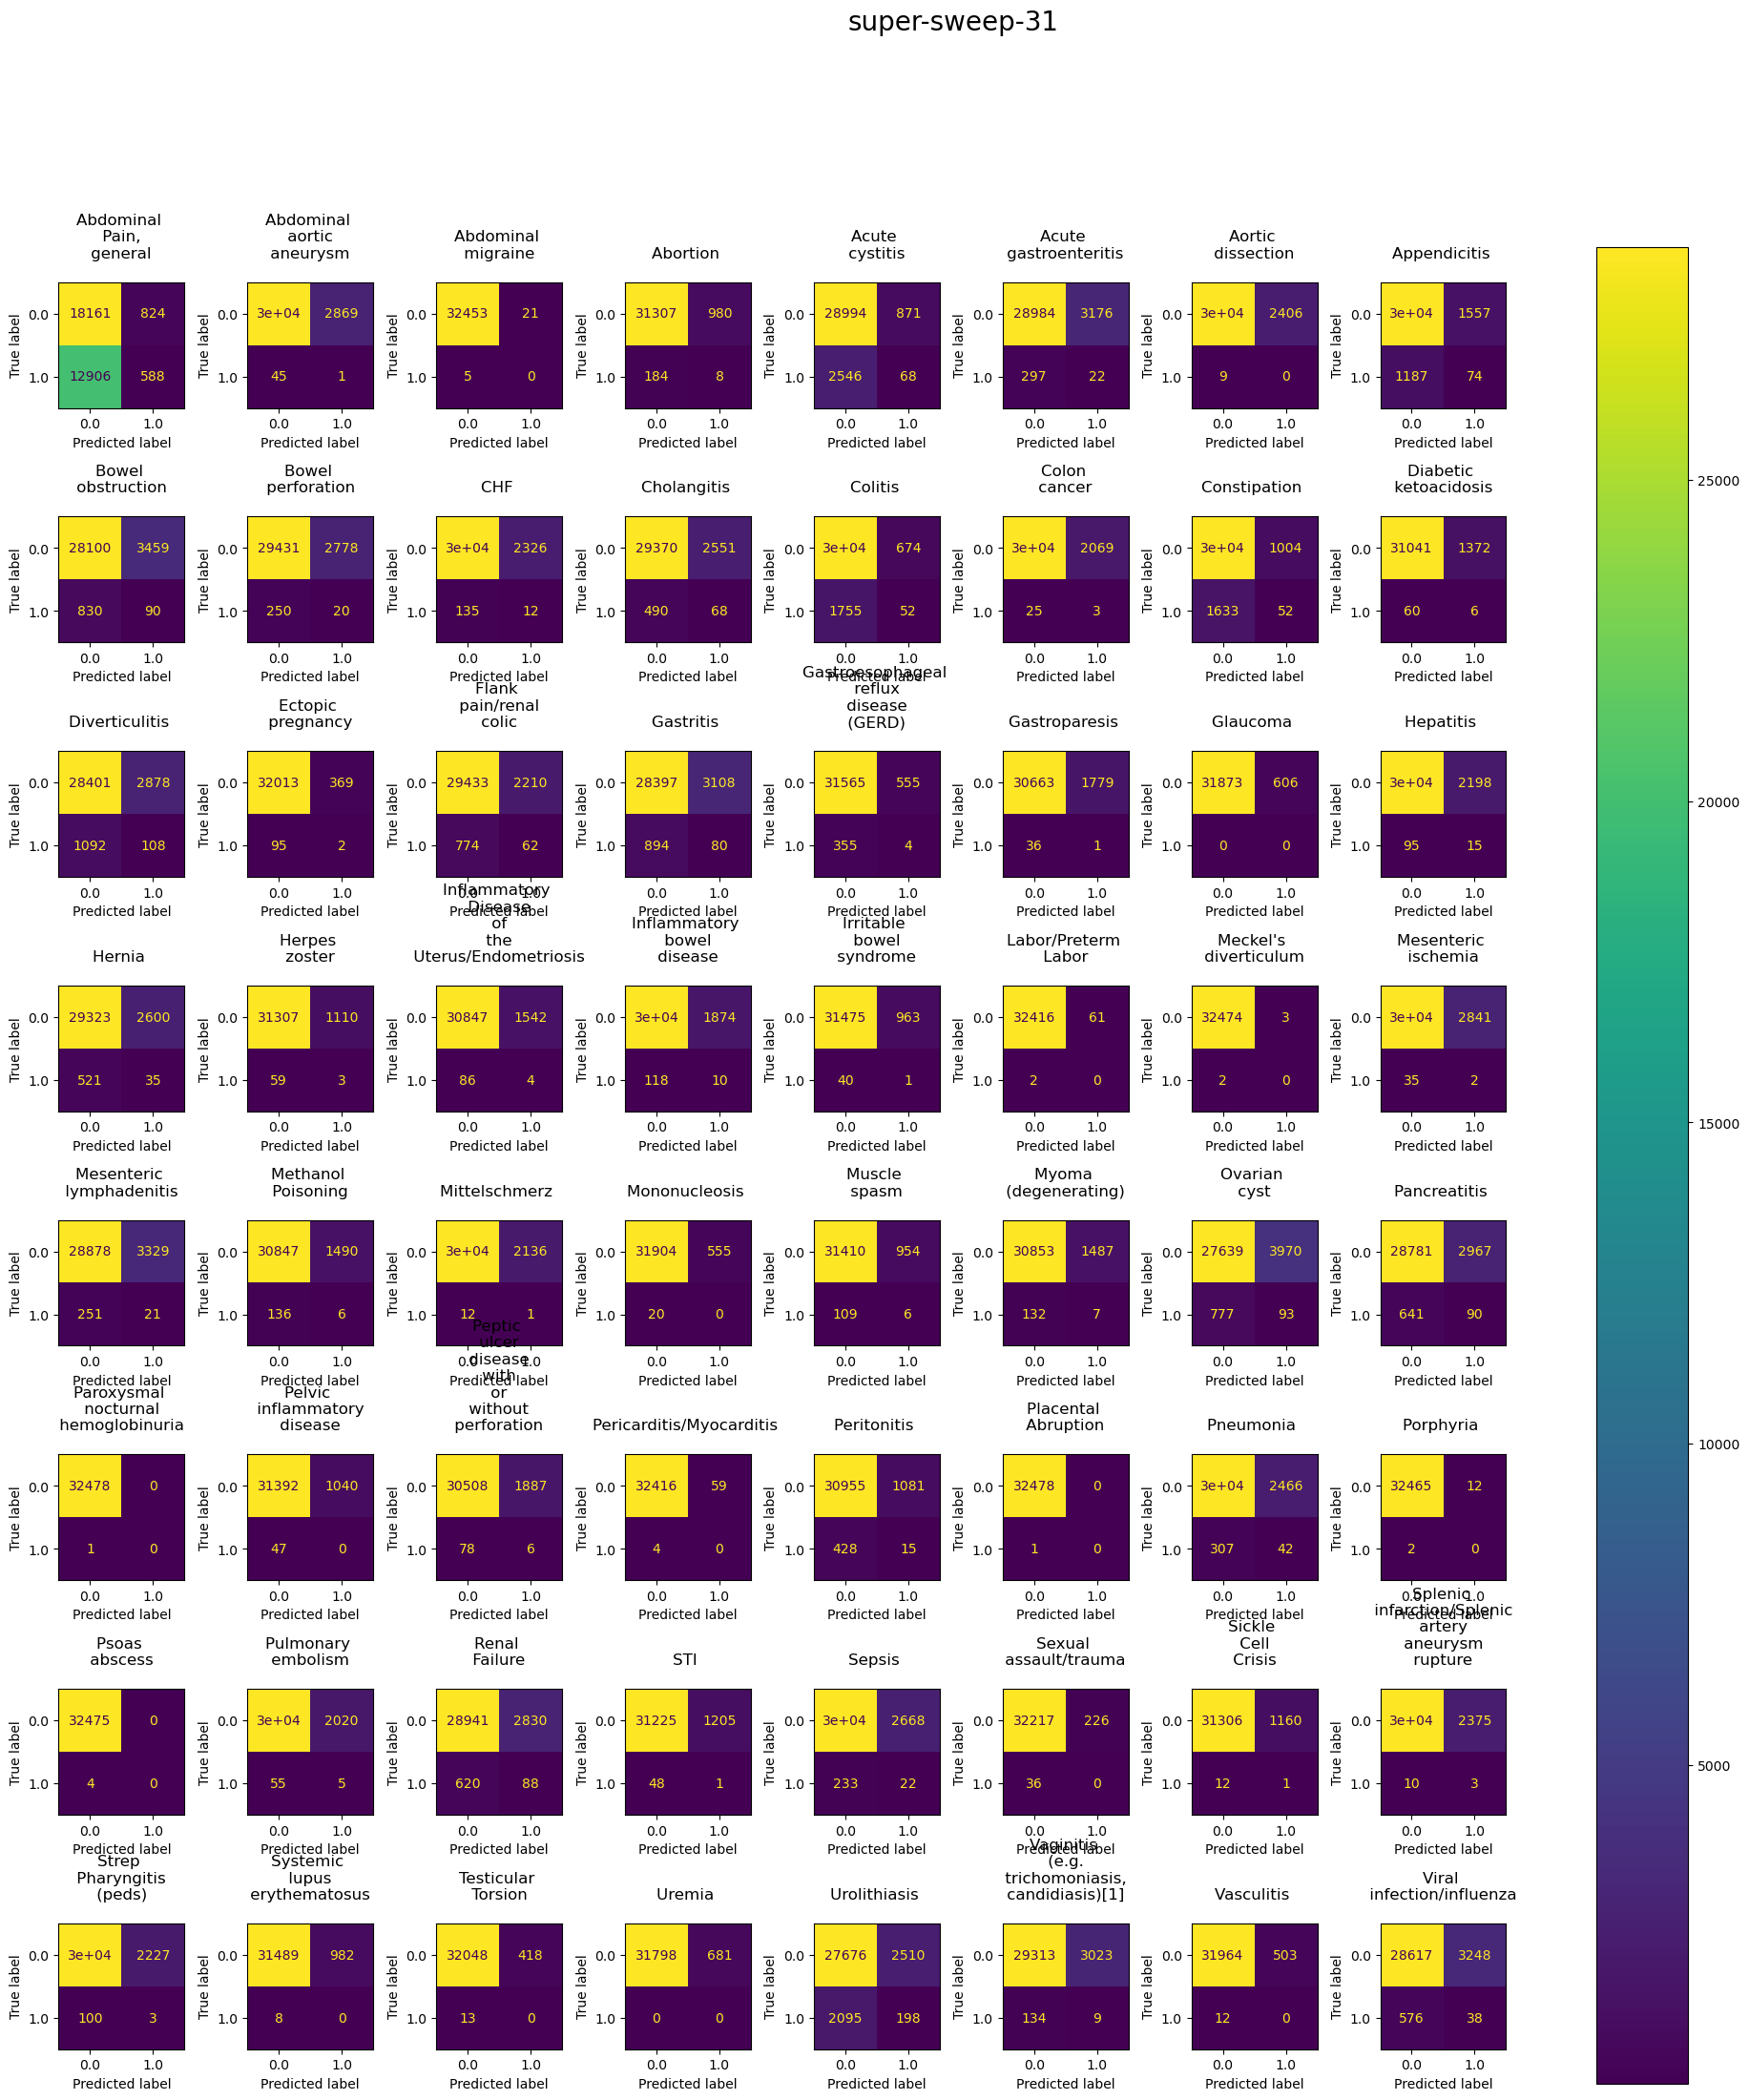

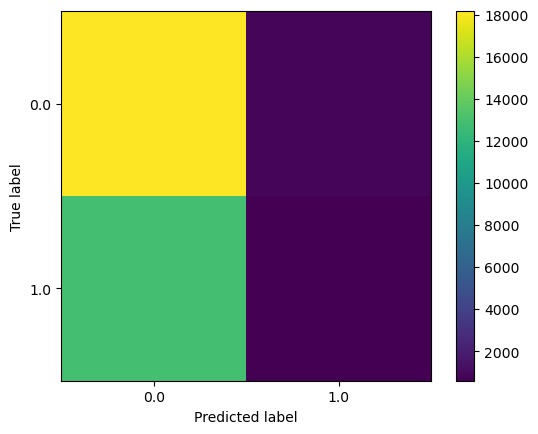

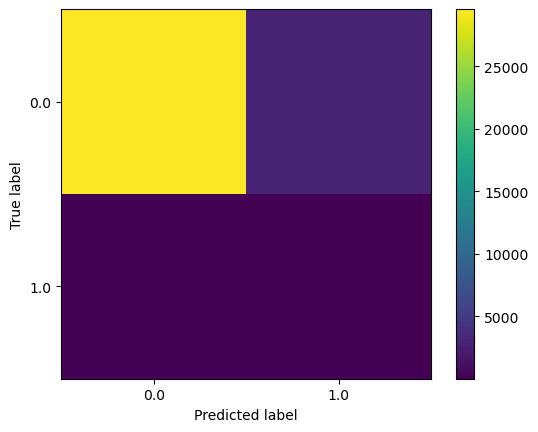

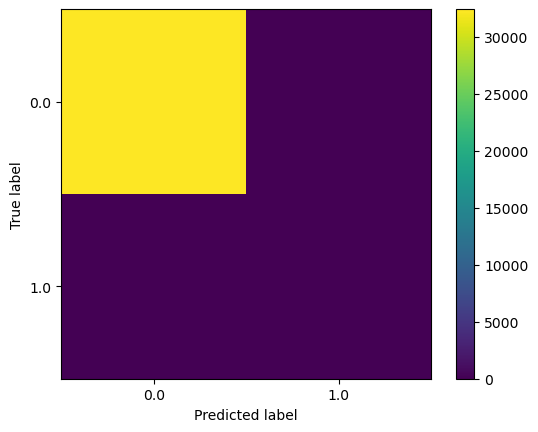

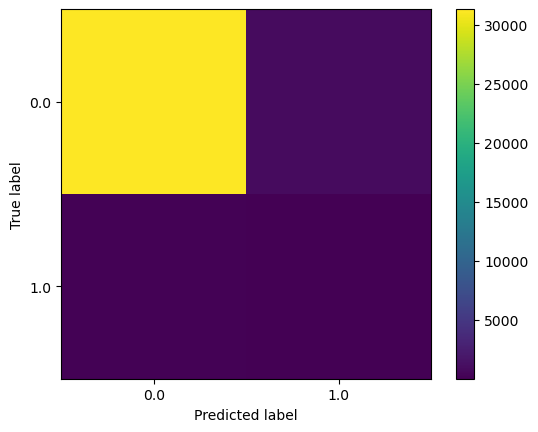

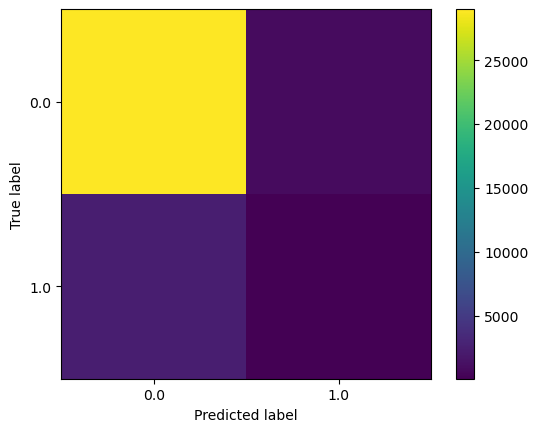

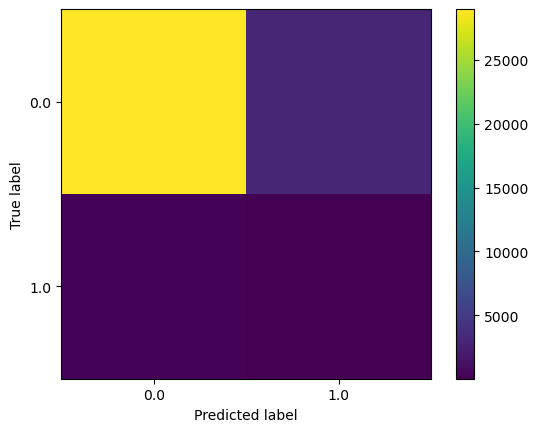

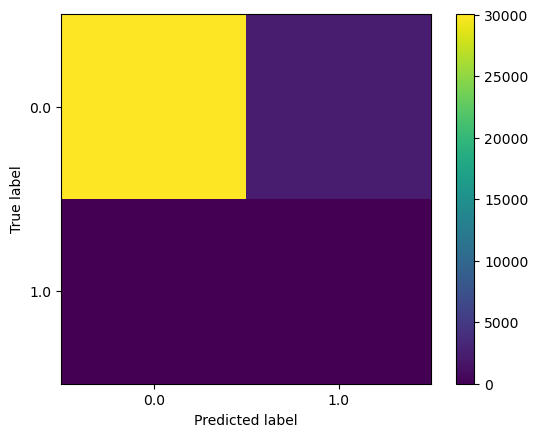

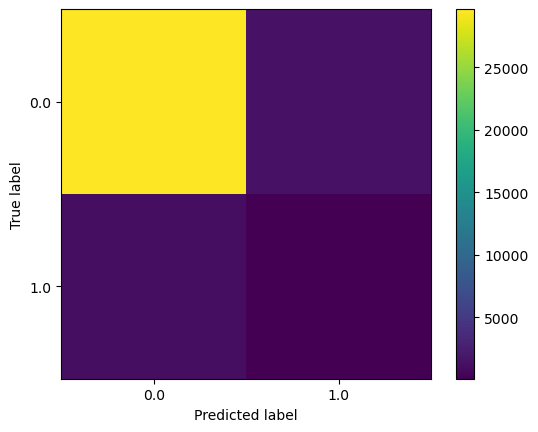

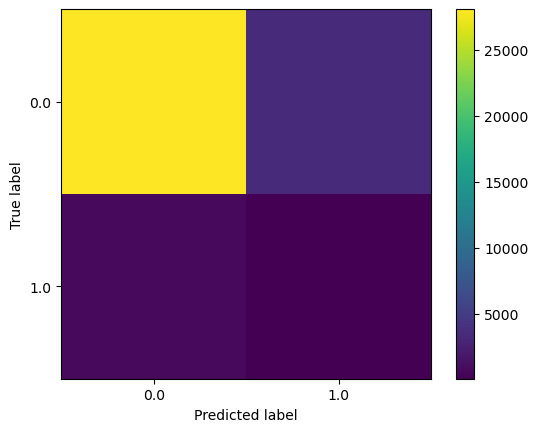

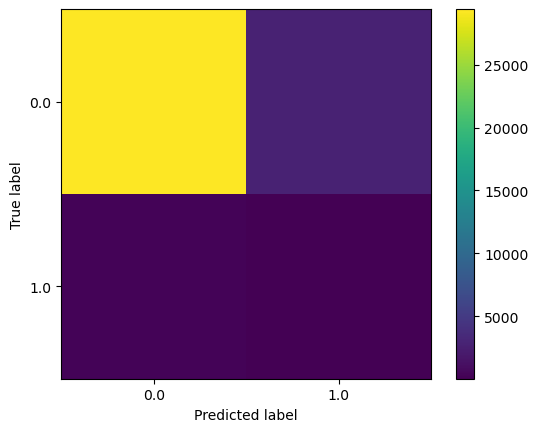

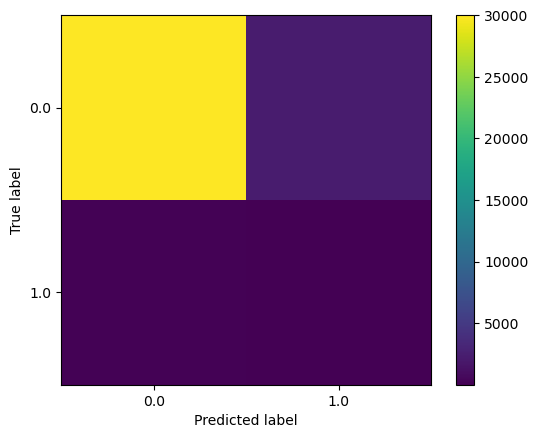

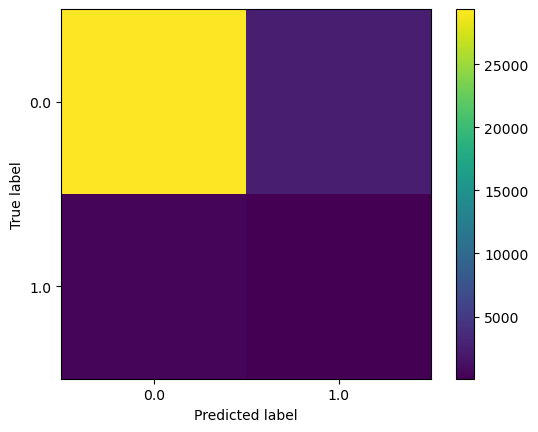

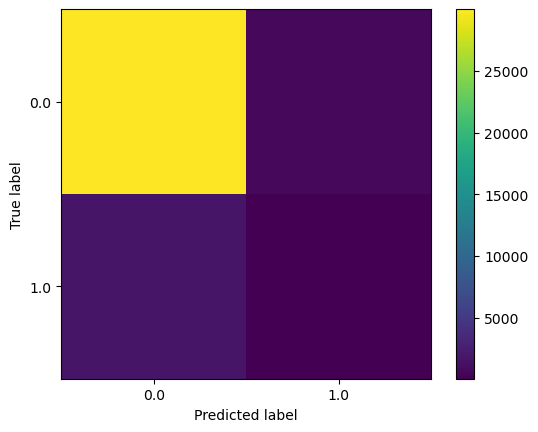

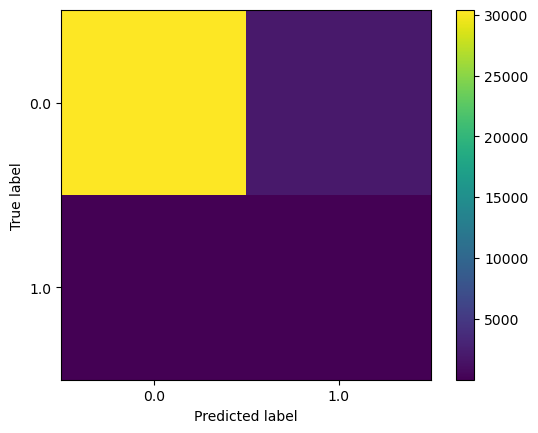

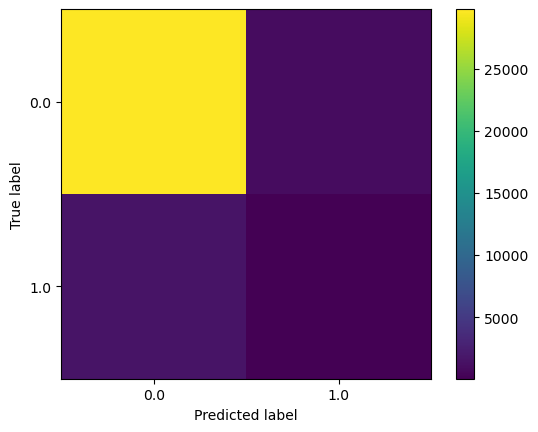

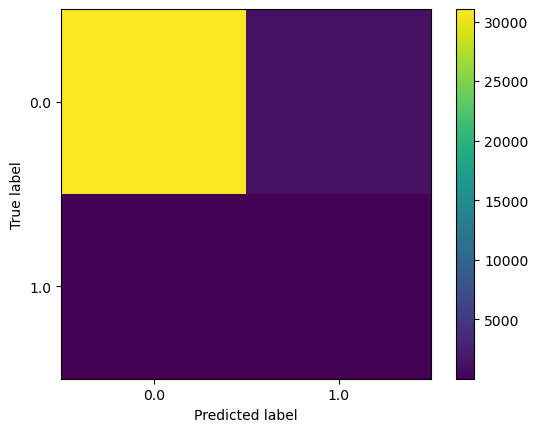

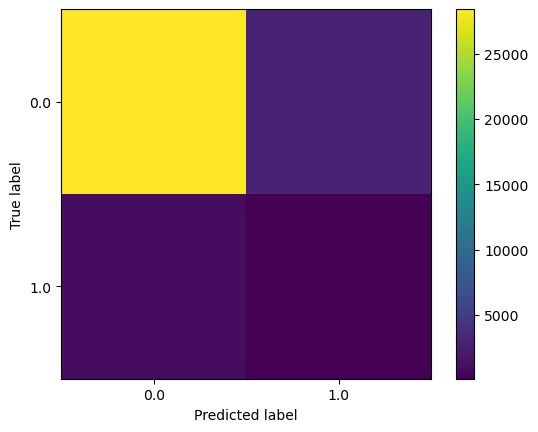

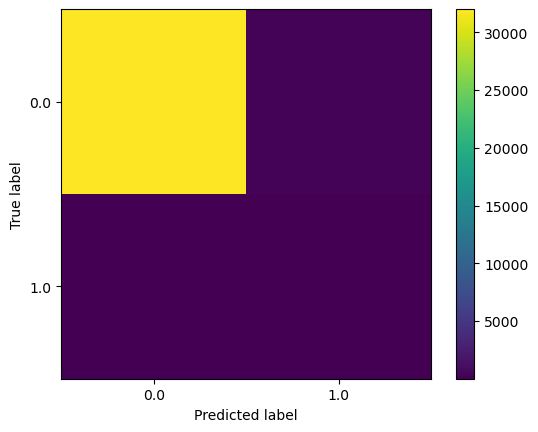

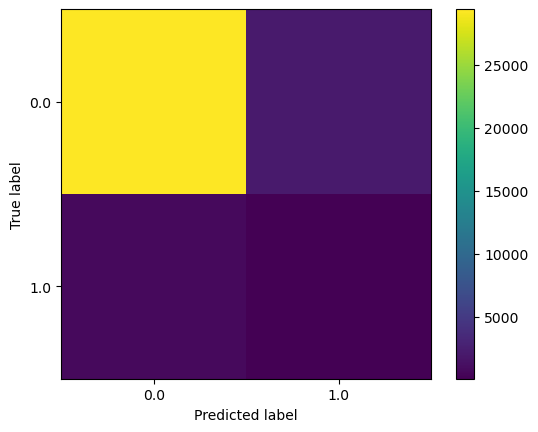

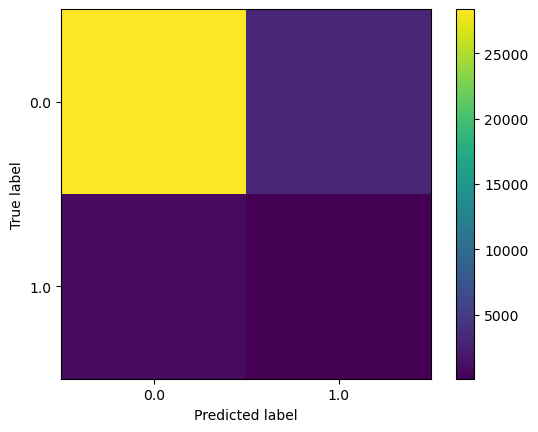

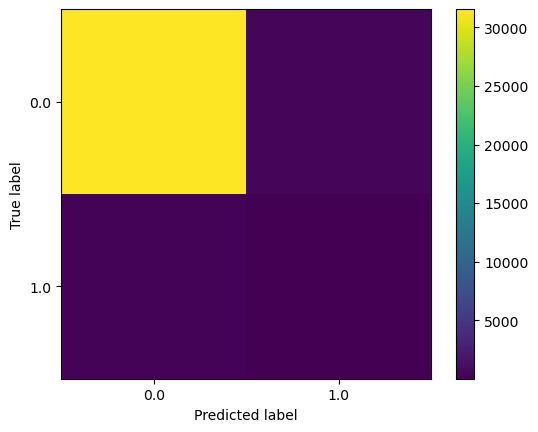

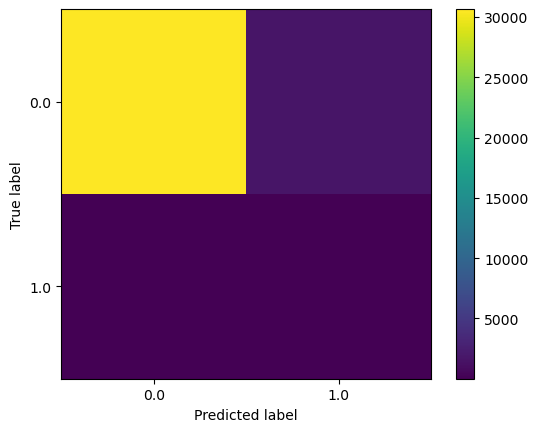

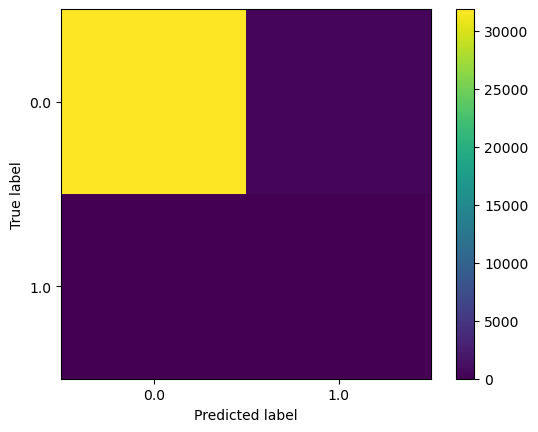

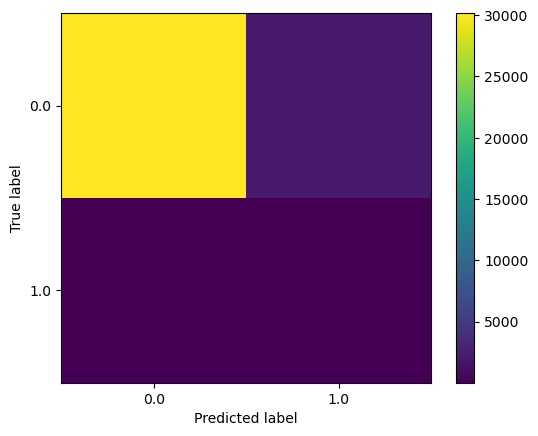

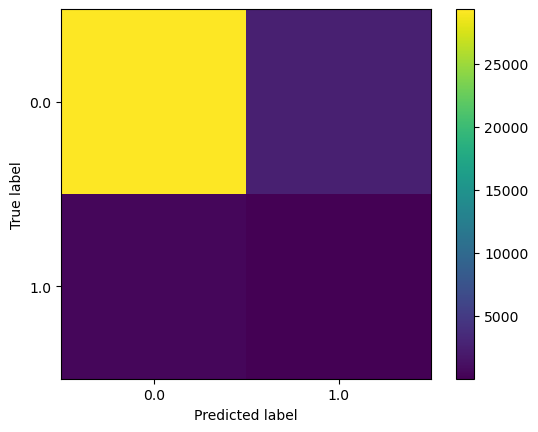

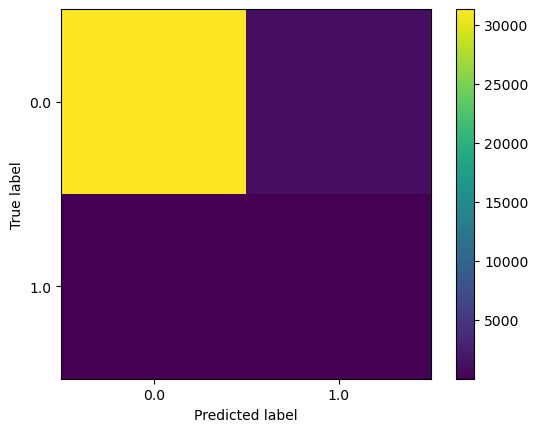

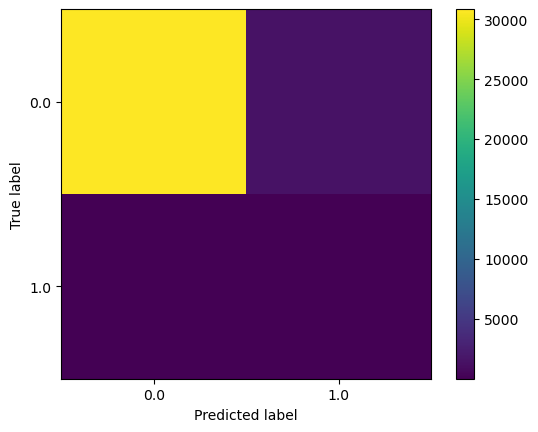

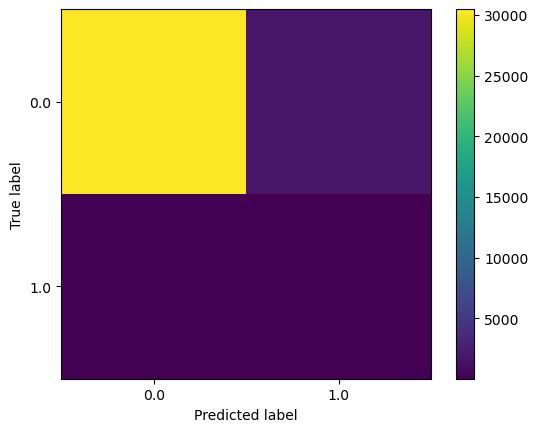

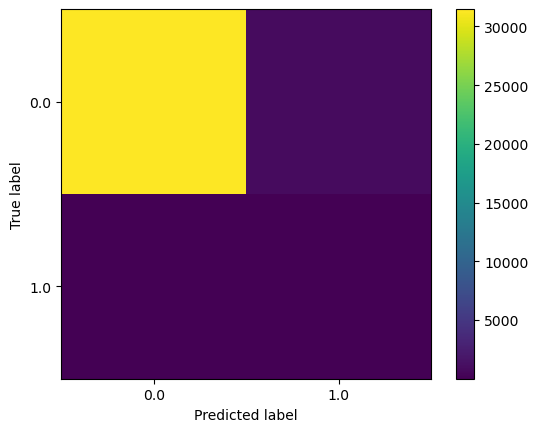

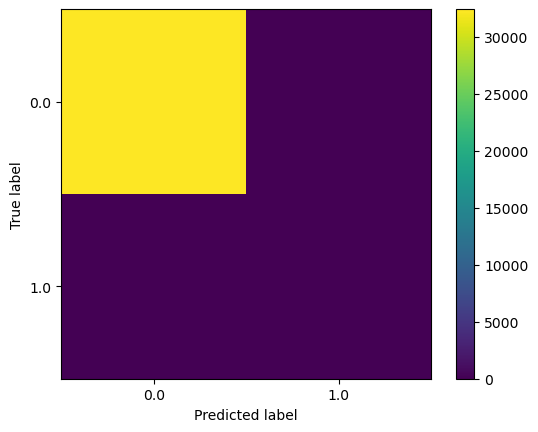

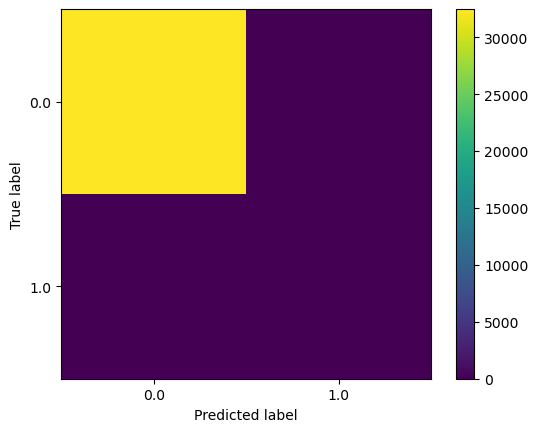

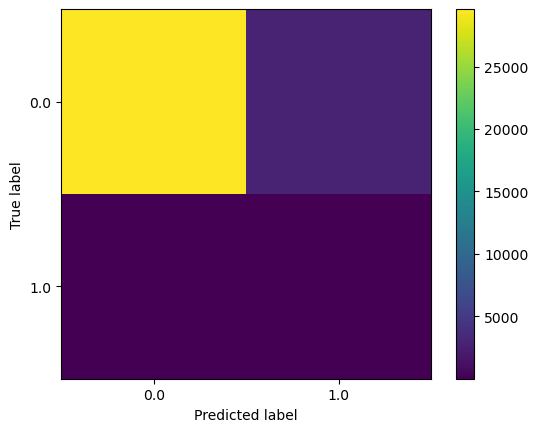

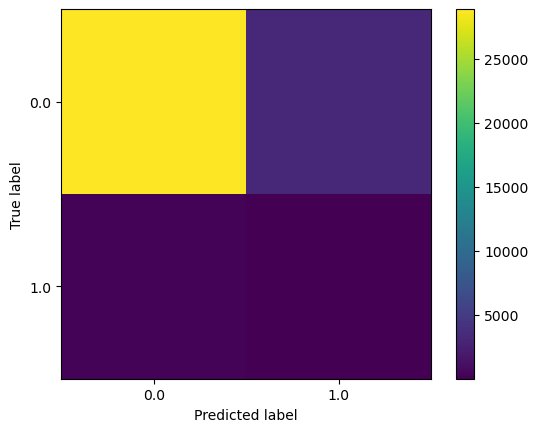

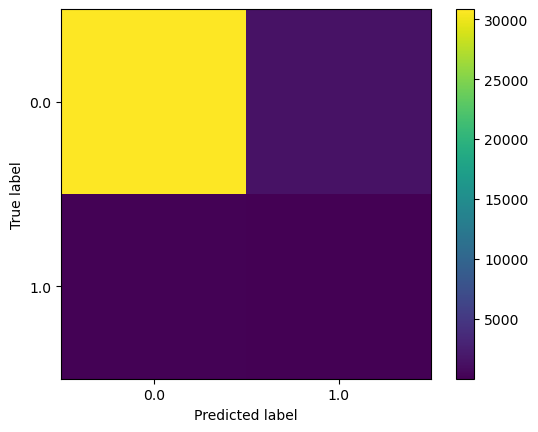

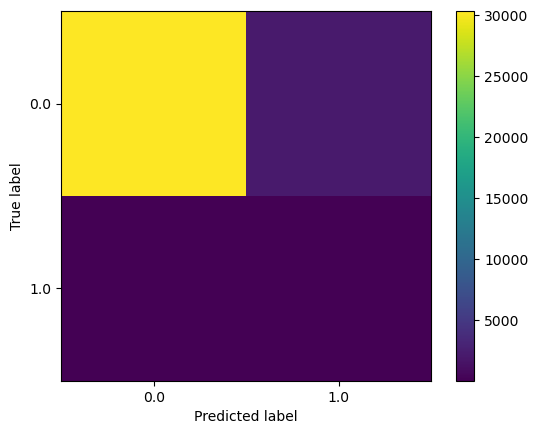

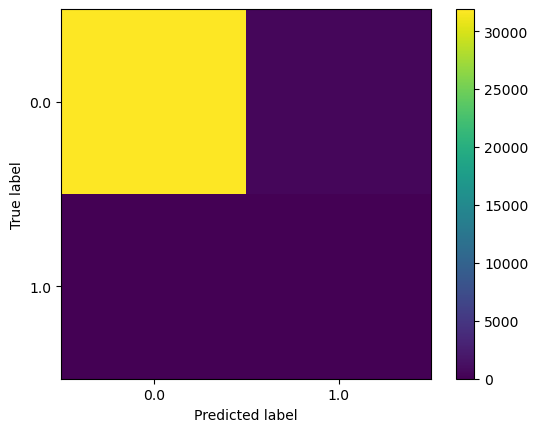

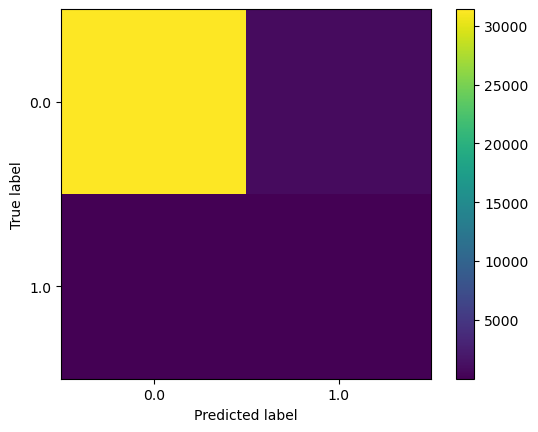

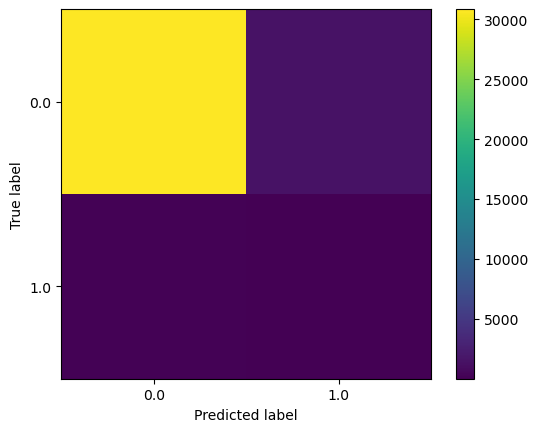

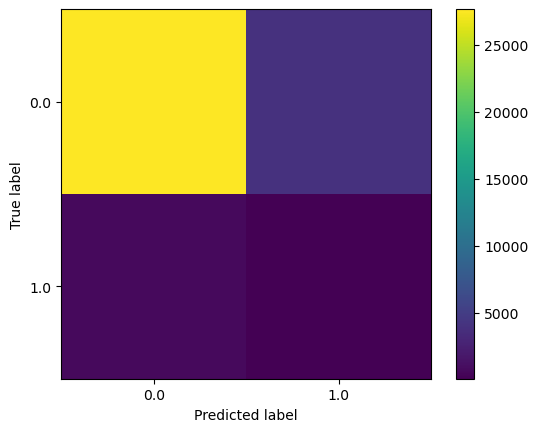

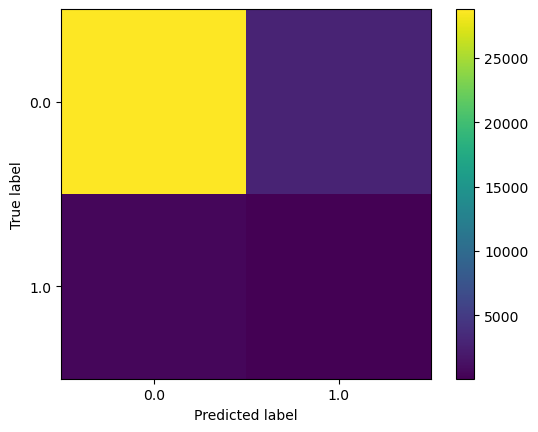

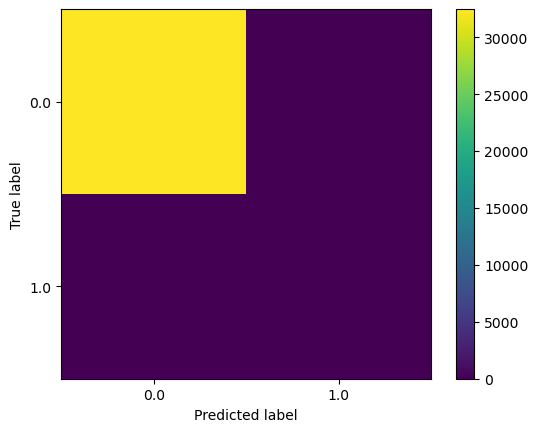

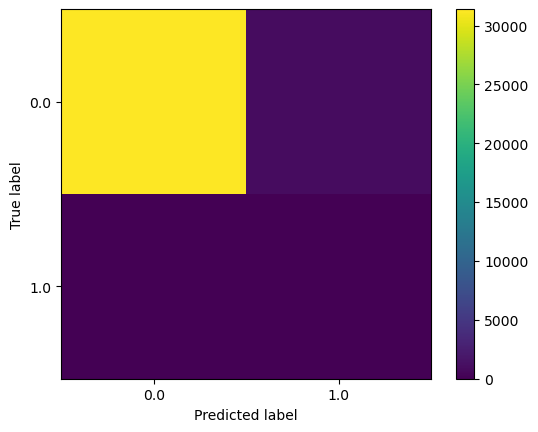

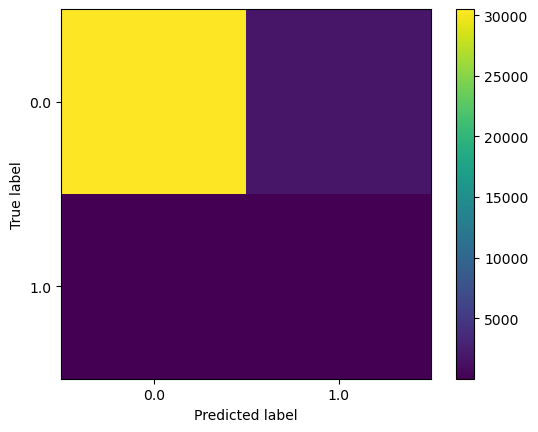

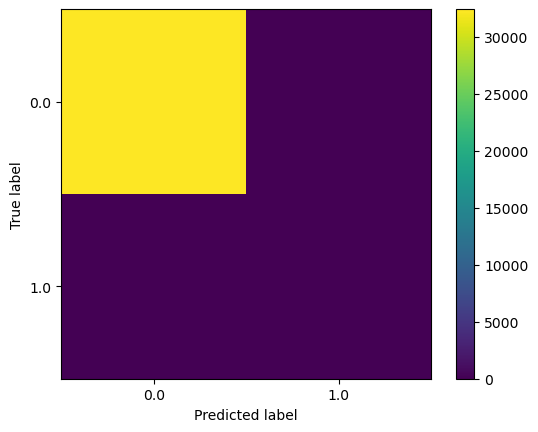

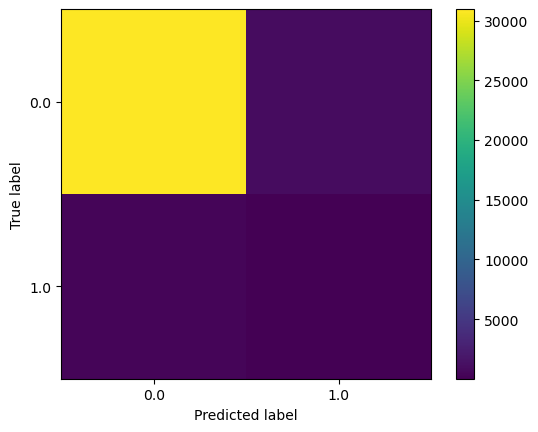

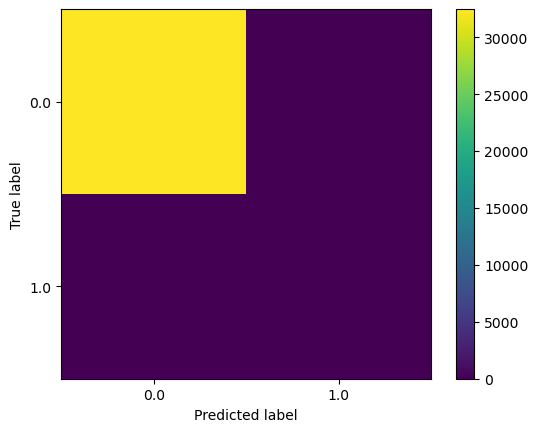

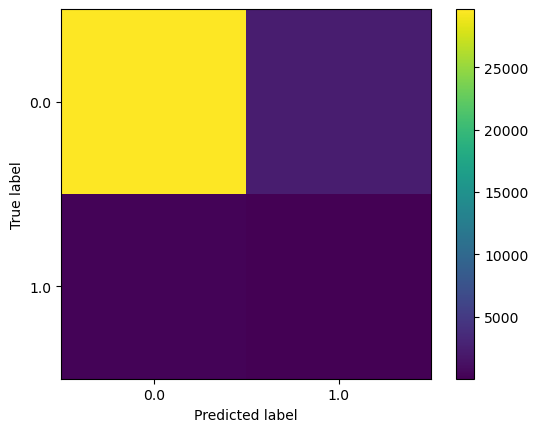

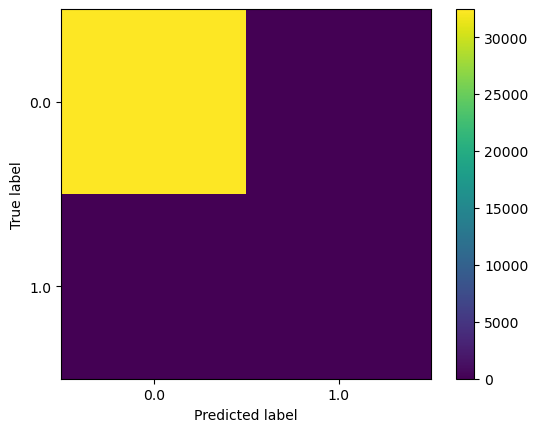

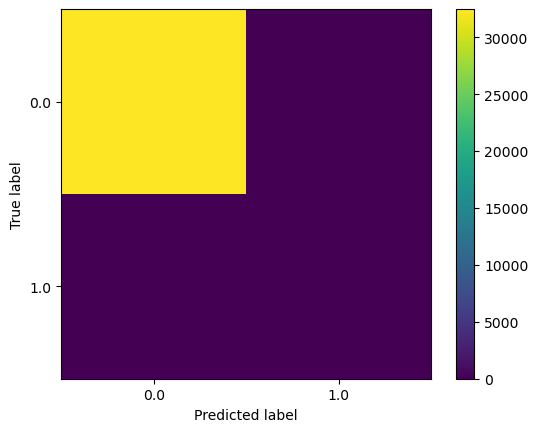

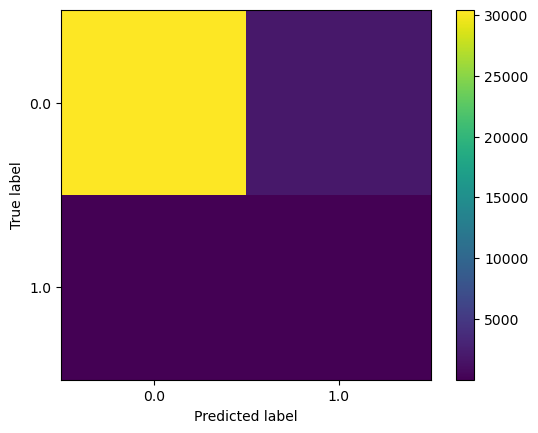

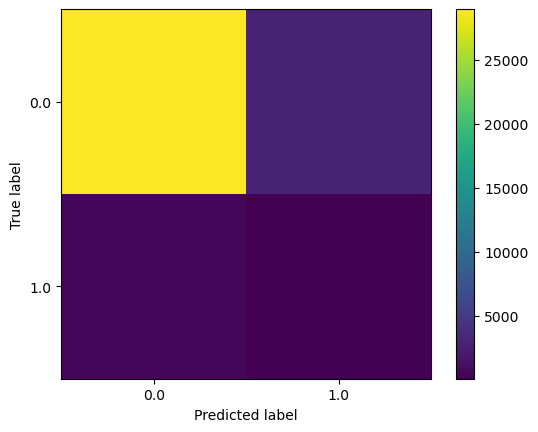

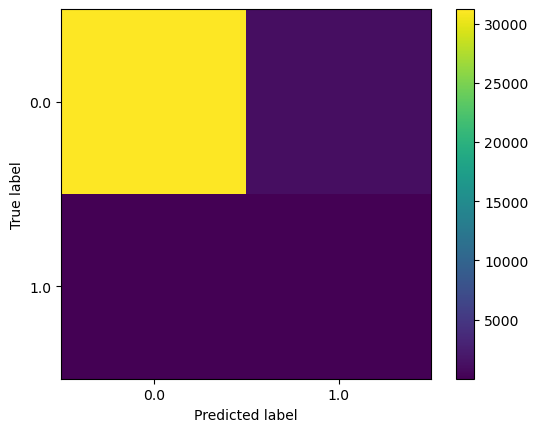

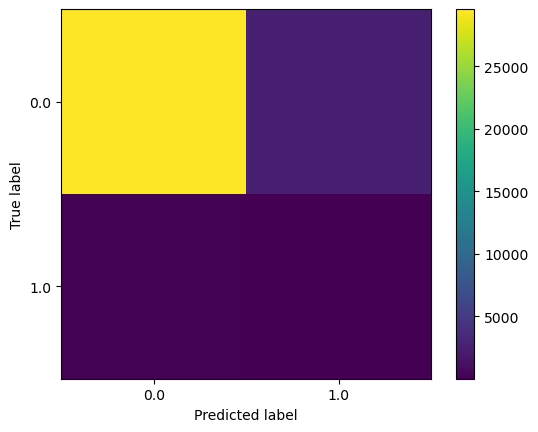

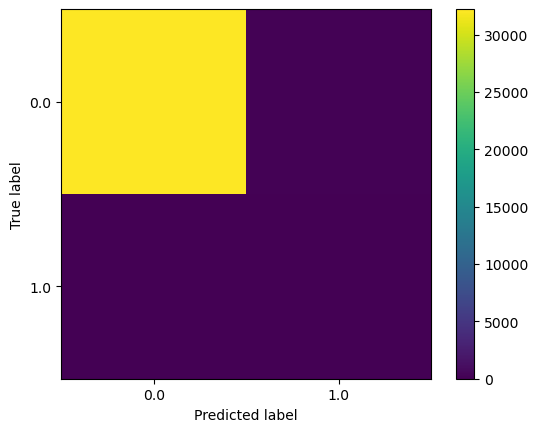

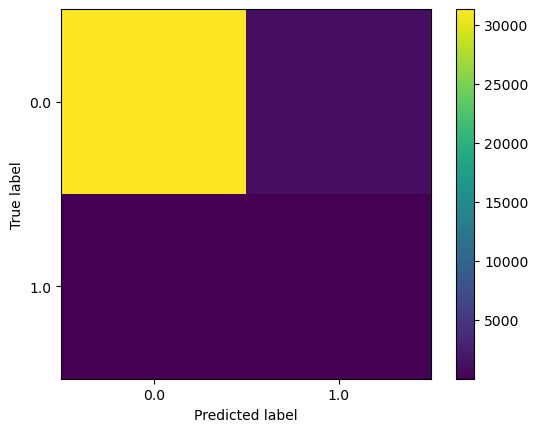

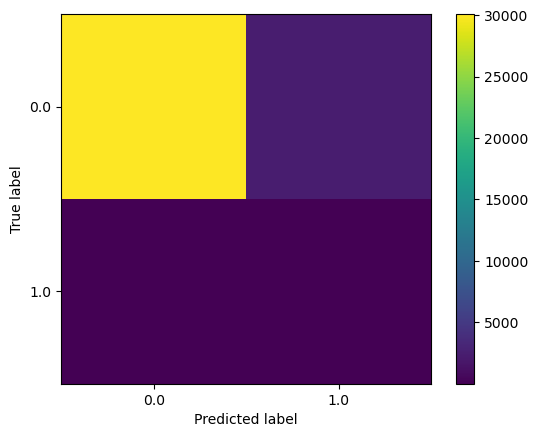

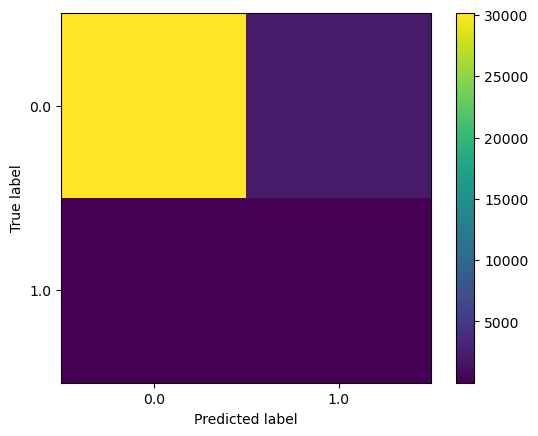

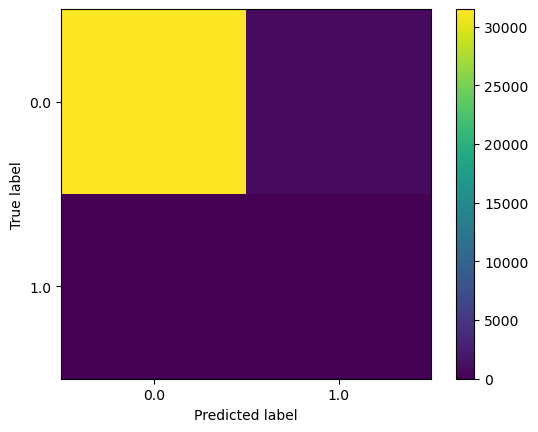

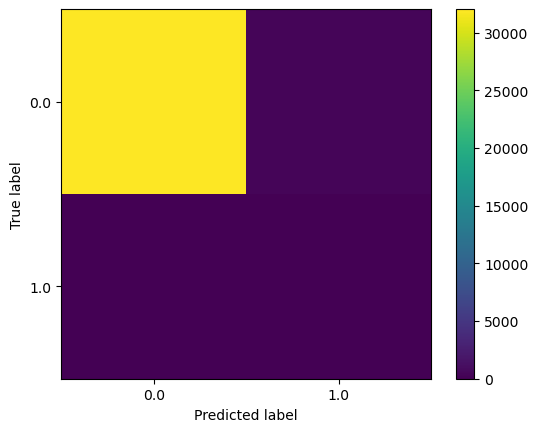

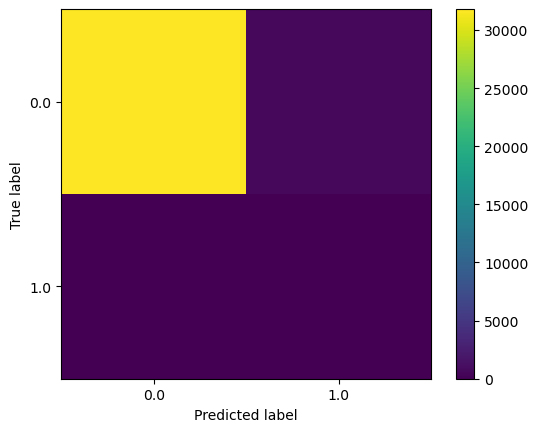

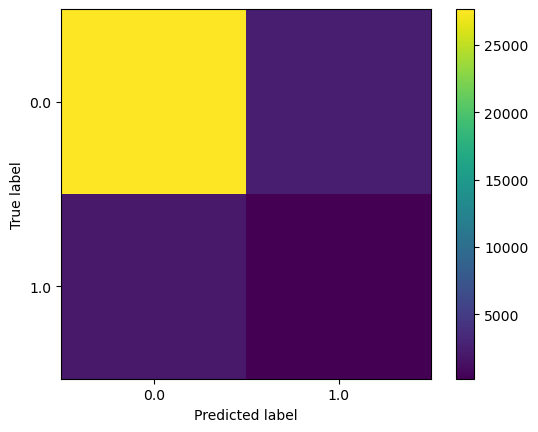

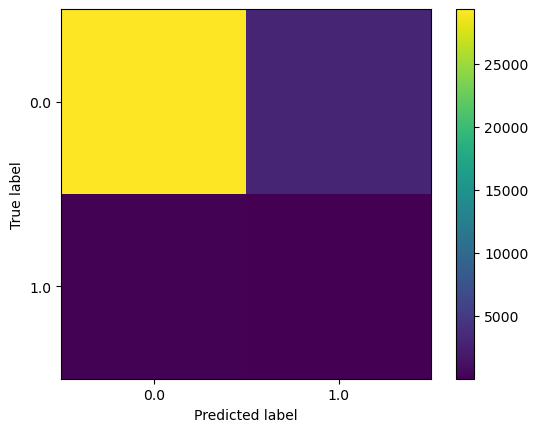

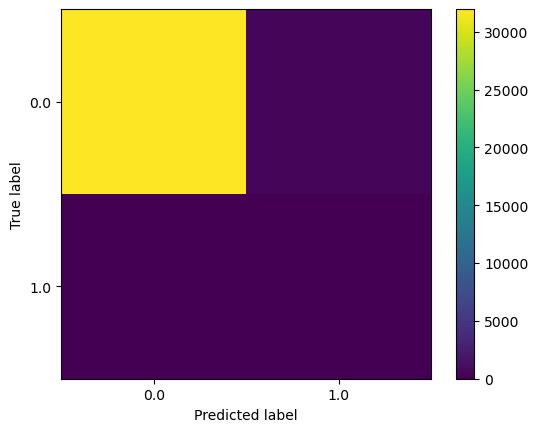

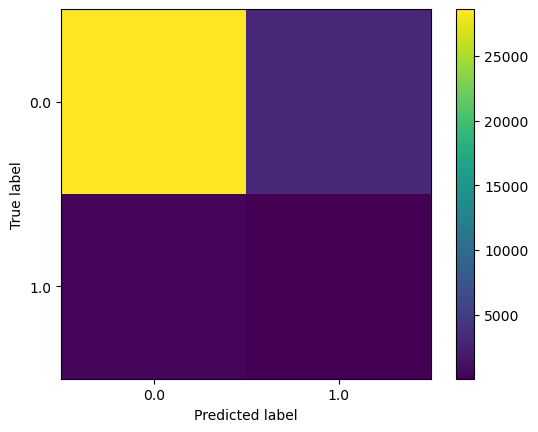

In [150]:
f, axes = plt.subplots(8, 8, figsize=(25, 25))
axes = axes.ravel()
for i, label in zip(range(64), label_list):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test_input.cpu().detach().numpy()[:, i],
        out.cpu().detach().numpy()[:, i],
        include_values=False,
        #                                   normalize="true",
        #                                   display_labels=[0, i]
    )
    disp.plot(ax=axes[i])  # , values_format='.4g')
    label_words = label.split()
    label_words = twolists(label_words, ["\n"] * len(label_words))
    label_text = " ".join(label_words)
    print(label_text)

    disp.ax_.set_title(f"{label_text}")
    #     if i<10:
    #         disp.ax_.set_xlabel('')
    #     if i%5!=0:
    #         disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()
f.suptitle(f"{RUN_NAME}", fontsize=20)

plt.subplots_adjust(wspace=0.20, hspace=0.2)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [133]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

In [134]:
# precision_recall_fscore_support(y_test_input.cpu().detach().numpy(), out.cpu().detach().numpy())
class_report = pd.DataFrame(
    classification_report(
        y_test_input.cpu().detach().numpy(),
        out.cpu().detach().numpy(),
        output_dict=True,
        target_names=label_list,
    )
).T

/gpfs/milgram/project/rtaylor/vs428/conda_envs/factcheck_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/milgram/project/rtaylor/vs428/conda_envs/factcheck_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/milgram/project/rtaylor/vs428/conda_envs/factcheck_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to con

In [135]:
with pd.option_context("display.max_rows", None):
    display(class_report.sort_values("support", ascending=False))

,precision,recall,f1-score,support
samples avg,0.014710,0.055178,0.019816,35509.0
micro avg,0.019451,0.057619,0.029084,35509.0
weighted avg,0.182548,0.057619,0.054065,35509.0
macro avg,0.017410,0.051006,0.014973,35509.0
"Abdominal Pain, general",0.416431,0.043575,0.078894,13494.0
Acute cystitis,0.072417,0.026014,0.038278,2614.0
Urolithiasis,0.073117,0.086350,0.079184,2293.0
Colitis,0.071625,0.028777,0.041058,1807.0
Constipation,0.049242,0.030861,0.037942,1685.0
Appendicitis,0.045371,0.058684,0.051176,1261.0
